<a href="https://colab.research.google.com/github/berry2971/senti-dict-yes24/blob/master/senti_dict_yes24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이상훈·최정·김종우(2016), 영역별 맞춤형 감성사전 구축을 통한 영화리뷰 감성분석
+
Word2Vec

In [0]:
##### Mount Google drive
from google.colab import drive
drive.mount('/content/gdrive/')

In [0]:
##### Connect with db (raw text)
import sqlite3
con1 = sqlite3.connect('/content/gdrive/My Drive/senti/result_2019.db')
cur1 = con1.cursor()

In [0]:
##### Connect with db (analyzed text)
con2 = sqlite3.connect('/content/gdrive/My Drive/senti/result_2019_analyzed.db')
con2.execute('CREATE TABLE analysis (RAW TEXT, TAGGED TEXT, REVIEW_STAR_CONTENT INTEGER, REVIEW_STAR_EDITION INTEGER)')

In [0]:
##### Prepare pos tagger
# When Using konlpy.tag.Okt
#!pip install konlpy
#from konlpy.tag import Okt
#okt = Okt()

# When Using Mecab
!pip install -v python-mecab-ko
import mecab
mecab = mecab.MeCab()

In [0]:
##### Pos tag and save it into database
count = 0
for row in cur1.execute("SELECT review_content, review_star_content, review_star_edition FROM reviews"): 
  con2.execute('INSERT INTO analysis (RAW, TAGGED, REVIEW_STAR_CONTENT, REVIEW_STAR_EDITION) VALUES (?, ?, ?, ?)', [row[0], str(mecab.pos(row[0])), row[1], row[2]])
  #print(row)
  #print(okt.pos(row[0]))
  #print([token for token in okt.pos(row[0]) if token[1]=='Adjective'])
  
  # Check progress and Commit database
  if count % 50000 == 0:
    count = count + 1
    con2.commit()
    print(count)

con2.commit()

In [0]:
##### Load database(max_positive, max_negative)
con3 = sqlite3.connect('/content/gdrive/My Drive/senti/result_2019_analyzed.db')
cur3 = con3.cursor()

count = 0
num_max_positive = 0
num_max_negative = 0
max_positive = []   # Objects of positive reviews: REVIEW_STAR_CONTENT + REVIEW_STAR_EDITION == 10
max_negative = []   # Objects of negative reviews: REVIEW_STAR+CONTENT + REVIEW_STAR_EDITION <= 7

# For get distribution
review_star_dist = []
for i in range(9):
  review_star_dist.append(0)

for row in cur3.execute('SELECT * FROM analysis'):
  # Check progress
  count = count + 1
  if count % 50000 == 0:
    print(count)
  
  # Create max_positive, max_negative
  # There are many reviews which have perfect score, but there are few reviews which have low score.
  # So we set 'positive' as 'content score'+'edition score'==10 and 'negative' as 'content score'+'edition score'<=7
  review_star_content = row[2]
  review_star_edition = row[3]
  review_star_sum = review_star_content + review_star_edition
  review_star_dist[review_star_sum - 2] += 1

  if review_star_sum == 10:
    if num_max_positive < 100000:
      max_positive.append(row)
    num_max_positive = num_max_positive + 1
  if review_star_sum < 8:
    if num_max_negative < 100000:
      max_negative.append(row)
    num_max_negative = num_max_negative + 1

print("number of max_positive : {a}, number of picked max_positive : {b}".format(a = num_max_positive, b = len(max_positive)))
print("number of max_negative : {a}, number of picked max_negative : {b}".format(a = num_max_negative, b = len(max_negative)))

50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000
700000
750000
number of max_positive : 494226, number of picked max_positive : 100000
number of max_negative : 53584, number of picked max_negative : 53584


In [0]:
review_star_dist

[2410, 749, 2789, 2985, 23223, 21426, 135166, 68379, 494226]

별점 10개 / 별점 2개로 했을 때
가장 긍정적인 리뷰: 494226개
가장 부정적인 리뷰: 2410개

별점 10개 / 별점 2~4개로 했을 때
가장 긍정적인 리뷰: 494226개
가장 부정적인 리뷰: 5950개

별점 10개 / 별점 2~7개로 했을 때
가장 긍정적인 리뷰: 494226개
가장 부정적인 리뷰: 53584개

In [0]:
##### Parse into tuples
import re
parsed_positive_documents = []   # [[(안녕, IC), (~, SL)], [(나, NNP), (도, JX)], …]
parsed_negative_documents = []   # [[(안녕, IC), (~, SL)], [(나, NNP), (도, JX)], …]

for positive in max_positive:
  parsed_positive_document = []
  document = positive[1]
  word_and_pos_list = re.findall("\((.+?)\)", document)
  for word_and_pos in word_and_pos_list:
    splited = word_and_pos.split(sep=", ")
    if len(splited)==1:
      continue
    word = splited[0].strip("'").strip('"')
    pos = splited[1].strip("'").strip('"')
    parsed_positive_document.append((word, pos))
  parsed_positive_documents.append(parsed_positive_document)

for negative in max_negative:
  parsed_negative_document = []
  document = negative[1]
  word_and_pos_list = re.findall("\((.+?)\)", document)
  for word_and_pos in word_and_pos_list:
    splited = word_and_pos.split(sep=", ")
    if len(splited)==1:
      continue
    word = splited[0].strip("'").strip('"')
    pos = splited[1].strip("'").strip('"')
    parsed_negative_document.append((word, pos))
  parsed_negative_documents.append(parsed_negative_document)

In [0]:
##### Create Standard words
parsed_posv_documents_integrated = []
parsed_negv_documents_integrated = []   # [(안녕, IC), (~, SL), (나, NNP), (도, JX), …]

for d in parsed_posv_documents:
  for token in d:
    if token[1]=='VA':
      parsed_posv_documents_integrated.append(token)

for d in parsed_negv_documents:
  for token in d:
    if token[1]=='VA':
      parsed_negv_documents_integrated.append(token)

from nltk import FreqDist
dist_positive = FreqDist(parsed_posv_documents_integrated)
dist_negative = FreqDist(parsed_negv_documents_integrated)

print("Total token number of positive reviews : {}".format(len(parsed_posv_documents_integrated)))
print(dist_positive.most_common(30))
print("Total token number of negative reviews : {}".format(len(parsed_negv_documents_integrated)))
print(dist_negative.most_common(30))

with open("/content/gdrive/My Drive/senti/result_2019_standard_words.txt", "w", encoding="utf8") as standard_words:
  for p in dist_positive.most_common(30):
    word = p[0][0]
    freq = p[1]
    standard_words.write(word+"\t"+str(freq)+"\n")
  standard_words.write("\n")
  for n in dist_negative.most_common(30):
    word = n[0][0]
    freq = n[1]
    standard_words.write(word+"\t"+str(freq)+"\n")

Total token number of positive reviews : 1106585
[(('좋', 'VA'), 178138), (('같', 'VA'), 160815), (('없', 'VA'), 123234), (('있', 'VA'), 119854), (('많', 'VA'), 108425), (('쉽', 'VA'), 55909), (('어렵', 'VA'), 19449), (('그렇', 'VA'), 19414), (('맛있', 'VA'), 18300), (('높', 'VA'), 16779), (('재미있', 'VA'), 16340), (('크', 'VA'), 15972), (('작', 'VA'), 15340), (('힘들', 'VA'), 13798), (('다르', 'VA'), 12034), (('적', 'VA'), 6994), (('재밌', 'VA'), 6569), (('깊', 'VA'), 6389), (('괜찮', 'VA'), 6242), (('싫', 'VA'), 6239), (('편하', 'VA'), 6153), (('즐겁', 'VA'), 6035), (('수많', 'VA'), 5864), (('짧', 'VA'), 5842), (('빠르', 'VA'), 5667), (('어떻', 'VA'), 5661), (('예쁘', 'VA'), 4814), (('늦', 'VA'), 4508), (('낮', 'VA'), 4278), (('새롭', 'VA'), 4152)]
Total token number of negative reviews : 525768
[(('없', 'VA'), 83525), (('같', 'VA'), 72904), (('있', 'VA'), 61191), (('좋', 'VA'), 60341), (('많', 'VA'), 45397), (('쉽', 'VA'), 17251), (('그렇', 'VA'), 14785), (('어렵', 'VA'), 7854), (('재미있', 'VA'), 7788), (('크', 'VA'), 7617), (('작', 'VA'), 

Standard words(긍정기준단어 집합, 부정기준단어 집합) 생성 결과

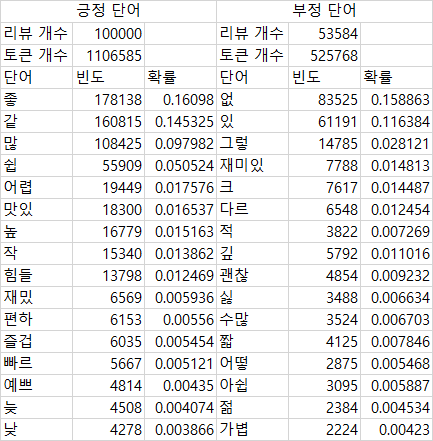

In [0]:
##### Preprocessing for Word2Vec
pdoc_posv = parsed_positive_documents
pdoc_negv = parsed_negative_documents

docs_va = []   # [[좋, 예쁘], [잘생겼, 괜찮], …]
docs_mag = []

for p1 in pdoc_posv:
  temp1 = []
  temp2 = []
  for p2 in p1:
    if p2[1] == 'VA':
      temp1.append(p2[0])
    if p2[1] == 'MAG':
      temp2.append(p2[0])
  if temp1: docs_va.append(temp1)
  if temp2: docs_mag.append(temp2)

for p1 in pdoc_negv:
  temp1 = []
  temp2 = []
  for p2 in p1:
    if p2[1] == 'VA':
      temp1.append(p2[0])
    if p2[1] == 'MAG':
      temp2.append(p2[0])
  if temp1: docs_va.append(temp1)
  if temp2: docs_mag.append(temp2)

from gensim.models import Word2Vec
model_va = Word2Vec(docs_va, size=100, window=5, min_count=5, workers=4, sg=1, sample=0.00001)
model_mag = Word2Vec(docs_mag, size=100, window=5, min_count=5, workers=4, sg=1, sample=0.00001)

# ↓↓↓↓↓↓↓↓↓↓ 결과 보기 ↓↓↓↓↓↓↓↓↓↓

In [0]:
##### Implement Word2Vec
# Input standard words list
posv_top_15 = ['좋', '같', '많', '쉽', '어렵', '맛있', '높', '작', '힘들', '재밌', '편하', '즐겁', '빠르', '예쁘', '늦', '낮']
negv_top_15 = ['없', '있', '그렇' ,'재미있', '크', '다르', '적', '깊', '괜찮', '싫', '수많', '짧', '어떻', '아쉽', '젊', '가볍']

posv_list = []
negv_list = []

# Print result of VA
for w in posv_top_15:
  model_result1 = model_va.wv.most_similar(w)
  for t in model_result1:
    posv_list.append(t)

for w in negv_top_15:
  model_result1 = model_va.wv.most_similar(w)
  for t in model_result1:
    negv_list.append(t)

print(posv_list)
print(negv_list)

[('맛있', 0.9892761707305908), ('같', 0.9864038825035095), ('예쁘', 0.9770746231079102), ('이쁘', 0.9745010137557983), ('쉽', 0.973604142665863), ('맛없', 0.9719046354293823), ('맵', 0.9717727899551392), ('색다르', 0.9690654873847961), ('맛나', 0.9687920212745667), ('많', 0.968306839466095), ('많', 0.9924103021621704), ('이쁘', 0.9901783466339111), ('예쁘', 0.9900972843170166), ('쉽', 0.9900779724121094), ('맵', 0.9900453090667725), ('맛없', 0.989933431148529), ('괜찮', 0.9885408878326416), ('편하', 0.9884423017501831), ('어렵', 0.9882574081420898), ('색다르', 0.98732990026474), ('없', 0.9958756566047668), ('어렵', 0.9951704144477844), ('적', 0.9950512051582336), ('편하', 0.9947733879089355), ('괜찮', 0.9944396018981934), ('힘들', 0.994149386882782), ('손색없', 0.9939283132553101), ('하얗', 0.9938487410545349), ('곱', 0.993812620639801), ('싱거우', 0.9937735795974731), ('맵', 0.998334527015686), ('맛없', 0.9982907772064209), ('예쁘', 0.9976456165313721), ('이쁘', 0.9976210594177246), ('손쉽', 0.9975968599319458), ('색다르', 0.9975218772888184), ('찹',

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
